In [25]:
# ================================
# 📌 [1] Imports and Configuration
# ================================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class Config:
    batch_size = 64
    num_epochs = 50
    lr = 1e-5
    all_domains = ["sketch", "art_painting", "cartoon", "photo"]
    test_domain = "photo"
    train_domains = []
    unseen_class = 6
    all_classes = list(range(7))
    num_classes = len(all_classes) - 1

# fix dependent attribute
Config.train_domains = [d for d in Config.all_domains if d != Config.test_domain]



Using device: cuda


In [26]:
# ===========================================
# 📌 [2] PACS Dataset Loader: Seen/Unseen split
# ===========================================

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

def make_pacs_dataloaders(root_dir):
    train_data, unseen_data, test_data = [], [], []

    for domain in Config.train_domains:
        folder = os.path.join(root_dir, domain)
        dataset = ImageFolder(folder, transform=transform)

        for i, (img, label) in enumerate(dataset):
            dom_idx = Config.all_domains.index(domain)
            if label == Config.unseen_class:
                unseen_data.append((img, label, dom_idx))
            else:
                train_data.append((img, label, dom_idx))

    # Test domain: exclude unseen class
    test_folder = os.path.join(root_dir, Config.test_domain)
    test_dataset = ImageFolder(test_folder, transform=transform)
    for img, label in test_dataset:
        if label != Config.unseen_class:
            dom_idx = Config.all_domains.index(Config.test_domain)
            test_data.append((img, label, dom_idx))
        else:
            unseen_data.append((img, label, dom_idx))

    train_loader = DataLoader(train_data, batch_size=Config.batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=Config.batch_size, shuffle=False)
    unseen_loader = DataLoader(unseen_data, batch_size=Config.batch_size, shuffle=False)

    return train_loader, test_loader, unseen_loader


In [27]:
# ========================
# 📌 [3] Model Architecture
# ========================

class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((7, 7))
        )
        self.fc = nn.Linear(256 * 7 * 7, 512)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.alpha * grad_output, None

class DomainClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.grl = GradientReversal.apply
        self.net = nn.Sequential(
            nn.Linear(512, 128), nn.ReLU(),
            nn.Linear(128, len(Config.train_domains))
        )

    def forward(self, x, alpha=1.0):
        return self.net(self.grl(x, alpha))

class EvidentialHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(512, Config.num_classes)

    def forward(self, x):
        evidence = torch.nn.functional.softplus(self.fc(x))  # Softplus is smoother than ReLU
        alpha = evidence + 1.0
        return alpha

In [28]:
# ==========================
# 📌 [4] Loss & Mixup Utility
# ==========================

def fixed_mixup(x1, x2, y1, y2, d1, d2):
    if y1 == y2 and d1 != d2:
        lam = np.random.beta(0.2, 0.2)
        mixed_x = lam * x1 + (1 - lam) * x2
        return mixed_x, y1, lam
    return None

class EvidentialLoss(nn.Module):
    def __init__(self, coeff=1.0, kl_coeff=0.01, reg_coeff=0.001):
        super().__init__()
        self.coeff = coeff
        self.kl_coeff = kl_coeff
        self.reg_coeff = reg_coeff

    def forward(self, alpha, targets):
        S = torch.sum(alpha, dim=1, keepdim=True)
        p = alpha / S

        ce_loss = -torch.sum(targets * torch.log(p), dim=1)
        error = (targets - p) ** 2
        var = p * (1 - p) / (S + 1)
        mse_loss = torch.sum(error + var, dim=1)
        kl = self.kl_divergence(alpha)
        reg = torch.mean(alpha - 1.0)  # Penalize evidence directly

        total_loss = ce_loss + self.coeff * mse_loss + self.kl_coeff * kl + self.reg_coeff * reg
        return total_loss.mean()

    def kl_divergence(self, alpha):
        K = alpha.size(1)
        beta = torch.ones((1, K)).to(alpha.device)
        S_alpha = torch.sum(alpha, dim=1, keepdim=True)
        S_beta = torch.sum(beta, dim=1, keepdim=True)

        lnB = torch.lgamma(S_alpha) - torch.sum(torch.lgamma(alpha), dim=1, keepdim=True)
        lnB_uni = torch.sum(torch.lgamma(beta), dim=1, keepdim=True) - torch.lgamma(S_beta)

        dg0 = torch.digamma(S_alpha)
        dg1 = torch.digamma(alpha)

        kl = torch.sum((alpha - beta) * (dg1 - dg0), dim=1, keepdim=True) + lnB + lnB_uni
        return kl.squeeze()



In [29]:
# ===========================
# 📌 [5] Train Model Function
# ===========================

def train_model(train_loader):
    feature_extractor = FeatureExtractor().to(device)
    domain_classifier = DomainClassifier().to(device)
    evidential_head = EvidentialHead().to(device)

    optimizer = torch.optim.Adam(
        list(feature_extractor.parameters()) +
        list(domain_classifier.parameters()) +
        list(evidential_head.parameters()),
        lr=Config.lr
    )
    criterion = EvidentialLoss()

    for epoch in range(Config.num_epochs):
        feature_extractor.train()
        domain_classifier.train()
        evidential_head.train()

        for images, labels, domains in train_loader:
            images, labels, domains = images.to(device), labels.to(device), domains.to(device)
            features = feature_extractor(images)

            p = epoch / Config.num_epochs
            grl_alpha = 2 / (1 + np.exp(-10 * p)) - 1

            domain_preds = domain_classifier(features, grl_alpha)
            domain_loss = nn.CrossEntropyLoss()(domain_preds, domains)

            mixed_features, mixed_labels = [], []
            for i in range(0, len(images)-1, 2):
                mix = fixed_mixup(features[i], features[i+1],
                                  labels[i], labels[i+1],
                                  domains[i], domains[i+1])
                if mix:
                    mixed_x, mixed_y, _ = mix
                    mixed_features.append(mixed_x)
                    mixed_labels.append(mixed_y)

            pure_alpha = evidential_head(features)
            labels_onehot = nn.functional.one_hot(labels, Config.num_classes).float().to(device)
            pure_loss = criterion(pure_alpha, labels_onehot)

            if mixed_features:
                mixed_features = torch.stack(mixed_features)
                mixed_labels = torch.tensor(mixed_labels, dtype=torch.long).to(device)
                mixed_alpha = evidential_head(mixed_features)
                mixed_onehot = nn.functional.one_hot(mixed_labels, Config.num_classes).float().to(device)
                mixed_loss = criterion(mixed_alpha, mixed_onehot)
            else:
                mixed_loss = 0

            total_loss = pure_loss + mixed_loss + 0.5 * domain_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{Config.num_epochs} | "
              f"Total Loss: {total_loss.item():.4f}")

    return feature_extractor, evidential_head


In [30]:
# ============================
# 📌 [6] Evaluate Seen & Unseen
# ============================

def seen_evaluate(feature_extractor, evidential_head, loader):
    feature_extractor.eval()
    evidential_head.eval()

    correct, total, uncertainties = 0, 0, []
    all_preds, all_labels = [], []
    correct_unc, incorrect_unc = [], []

    with torch.no_grad():
        for images, labels, _ in loader:
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)
            alpha = evidential_head(features)

            preds = torch.argmax(alpha, dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

            S = torch.sum(alpha, dim=1)
            unc = (Config.num_classes / S).cpu().tolist()
            uncertainties.extend(unc)

            mask = preds == labels
            correct += mask.sum().item()
            total += len(labels)
            correct_unc.extend([u for u, m in zip(unc, mask) if m])
            incorrect_unc.extend([u for u, m in zip(unc, ~mask)])

    acc = correct / total
    print(f"Seen Domain Accuracy: {acc*100:.2f}%")
    print(f"Avg Uncertainty: {np.mean(uncertainties):.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.show()

def unseen_evaluate(feature_extractor, evidential_head, loader):
    feature_extractor.eval()
    evidential_head.eval()

    uncertainties = []
    with torch.no_grad():
        for images, _, _ in loader:
            images = images.to(device)
            features = feature_extractor(images)
            alpha = evidential_head(features)
            S = torch.sum(alpha, dim=1)
            unc = (Config.num_classes / S).cpu().tolist()
            uncertainties.extend(unc)

    print(f"Unseen Class Avg Uncertainty: {np.mean(uncertainties):.4f}")
    plt.hist(uncertainties, bins=30)
    plt.title("Unseen Class Uncertainties")
    plt.show()


In [31]:
root_dir = "~/bhavyaaa/datasets/PACS/pacs_data"

In [32]:
train_loader, test_loader, unseen_loader = make_pacs_dataloaders(root_dir)


In [33]:
feature_extractor, evidential_head = train_model(train_loader)


Epoch 1/50 | Total Loss: 2.9290
Epoch 2/50 | Total Loss: 5.5492
Epoch 3/50 | Total Loss: 2.8547
Epoch 4/50 | Total Loss: 2.9698
Epoch 5/50 | Total Loss: 5.0646
Epoch 6/50 | Total Loss: 4.8365
Epoch 7/50 | Total Loss: 4.4897
Epoch 8/50 | Total Loss: 2.7463
Epoch 9/50 | Total Loss: 2.7414
Epoch 10/50 | Total Loss: 6.7286
Epoch 11/50 | Total Loss: 2.9637
Epoch 12/50 | Total Loss: 4.0004
Epoch 13/50 | Total Loss: 2.6610
Epoch 14/50 | Total Loss: 7.9170
Epoch 15/50 | Total Loss: 4.0448
Epoch 16/50 | Total Loss: 5.1966
Epoch 17/50 | Total Loss: 3.9142
Epoch 18/50 | Total Loss: 6.7095
Epoch 19/50 | Total Loss: 3.8138
Epoch 20/50 | Total Loss: 9.4511
Epoch 21/50 | Total Loss: 3.9635
Epoch 22/50 | Total Loss: 18.4823
Epoch 23/50 | Total Loss: 178.5587
Epoch 24/50 | Total Loss: 78.7171
Epoch 25/50 | Total Loss: 55.5638
Epoch 26/50 | Total Loss: 27.0793
Epoch 27/50 | Total Loss: 41.2187
Epoch 28/50 | Total Loss: 37.0638
Epoch 29/50 | Total Loss: 54.2570
Epoch 30/50 | Total Loss: 93.2659
Epoch 31/

Seen Domain Accuracy: 32.79%
Avg Uncertainty: 0.0010


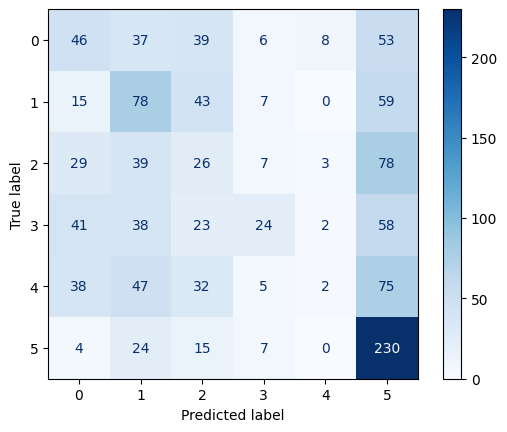

In [34]:
seen_evaluate(feature_extractor, evidential_head, test_loader)

Unseen Class Avg Uncertainty: 0.0013


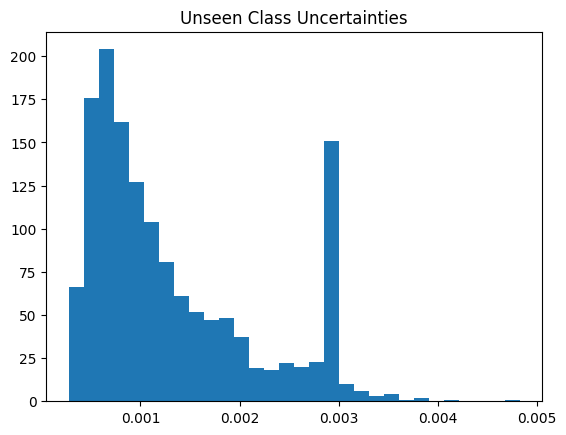

In [35]:
unseen_evaluate(feature_extractor, evidential_head, unseen_loader)